In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hate-speech-and-offensive-language-detection/train.csv


## Read the Data

In [2]:
import matplotlib.pyplot as plt
import re

In [3]:
train_data= pd.read_csv('/kaggle/input/hate-speech-and-offensive-language-detection/train.csv')
train_data.sample(9)

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
5433,3,1,2,0,1,@_thecrave only if it's funny tweets about ash...
18152,3,0,0,3,2,RT @Yankees: Congratulations Ichiro! That lead...
22743,6,0,6,0,1,When u hitting it from the back u gotta call h...
13779,3,0,3,0,1,Pedro is a little bitch cause he never DM me.
14134,3,1,2,0,1,RT @AlexDavisRaps: fuck. I forgot to wear a be...
7458,3,0,2,1,1,A nicca is hungry as hell
18394,6,0,6,0,1,RT @___Royals: When niggas try to act hard but...
13765,3,0,3,0,1,"Party at the house, come through bitches"
24193,3,1,2,0,1,lost a couple online matches in nhl14. bitch h...


## Analyse the Dataset

<Axes: xlabel='class'>

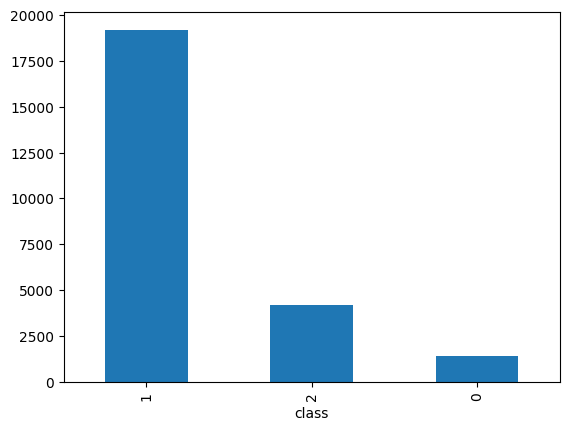

In [4]:
''' 0 : Hate speech
    1 : offensive_language
    2 : Neither hate nor offencive 
'''
train_data['class'].value_counts().plot(kind='bar')

<Axes: xlabel='count'>

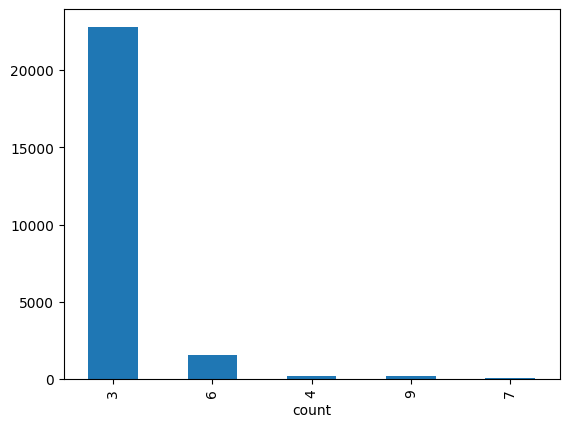

In [5]:
''' Count of annotations '''
train_data['count'].value_counts().plot(kind='bar')

<Axes: xlabel='hate_speech_count'>

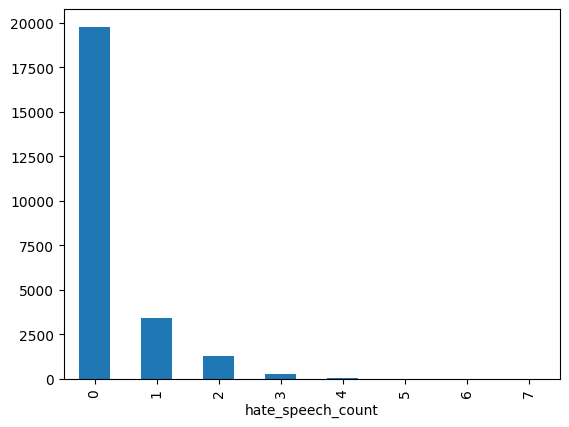

In [6]:
train_data['hate_speech_count'].value_counts().plot(kind='bar')

<Axes: xlabel='offensive_language_count'>

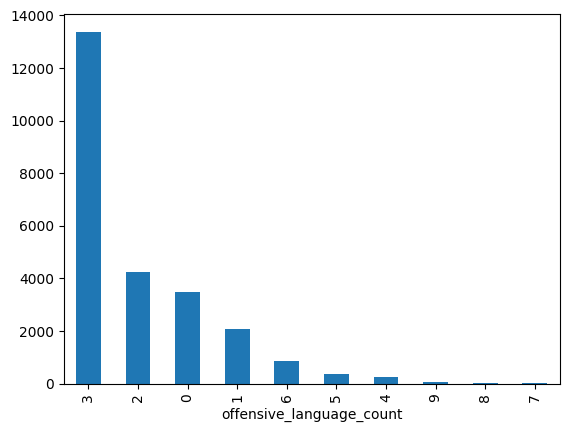

In [7]:
train_data['offensive_language_count'].value_counts().plot(kind='bar')

<Axes: xlabel='neither_count'>

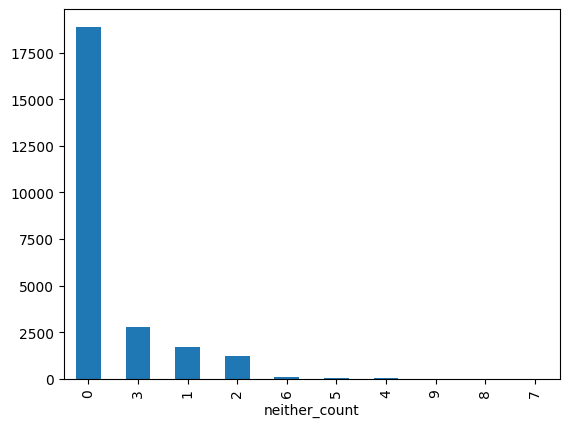

In [8]:
train_data['neither_count'].value_counts().plot(kind='bar')

## Clean the data
1. Remove the annotation.(!!)
2. Remove the username.
3. Remove the url.
4. Remove random no. like(&#128514)

In [9]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
stopword_set = stopwords.words('english')
lemma = WordNetLemmatizer()


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
def remove_stopword_lemmatize(sent):
#     nltk.download('wordnet')
    sent = word_tokenize(sent)
    new_sent = ''
    for word in sent:
        if word not in stopword_set:
#             new_sent+=lemma.lemmatize(word,pos='v')+ ' '
            new_sent+=word+' '
    return new_sent

In [11]:
def clean_tweet(x):
    pattern = r'@\w*\b'
    no_pattern = r'&#\w*\b'
    x = re.sub(no_pattern,'',x)
    x = re.sub(pattern,'',x)
    x = x.replace('RT ','')
    x = x.replace('NFN ','')
    x = re.sub('|!|:|"|;|\'|\.|','',x)
    return x

In [12]:
train_data['tweet'] = train_data['tweet'].apply(clean_tweet)

In [13]:
train_data['tweet'] = train_data['tweet'].apply(remove_stopword_lemmatize)

In [14]:
labels = train_data['class']
train_data.drop('class',axis=1,inplace=True)

## Split the dataset

In [15]:
train_data['tweet']

0        As woman shouldnt complain cleaning house & am...
1        boy dats coldtyga dwn bad cuffin dat hoe 1st p...
2        Dawg You ever fuck bitch start cry ? You confu...
3                                        look like tranny 
4        The shit hear might true might faker bitch tol...
                               ...                        
24778    yous muthaf***in lie right His TL trash Now , ...
24779    youve gone broke wrong heart baby , drove redn...
24780    young buck wan na eat dat nigguh like I aint f...
24781                   youu got wild bitches tellin lies 
24782    ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...
Name: tweet, Length: 24783, dtype: object

In [16]:
import tensorflow as tf

In [17]:
tweet_tokenizer=tf.keras.preprocessing.text.Tokenizer(oov_token="<oov>")
tweet_tokenizer.fit_on_texts(train_data['tweet'])


In [18]:
word_dict=tweet_tokenizer.word_index

In [19]:
sequences=tweet_tokenizer.texts_to_sequences(train_data['tweet'])

In [20]:
def get_max_len(t):
    max_len = 0
    total_words = []
    for i in t:
        max_len = max(max_len,len(i.split(' ')))
        total_words.extend(i.split(' '))
    return max_len,len(set(total_words))

max_len,total_words = get_max_len(list(train_data['tweet']))
max_len,total_words

(41, 30702)

In [21]:
padded_sequence=tf.keras.preprocessing.sequence.pad_sequences(sequences,maxlen=max_len,padding="pre",truncating="pre")

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(padded_sequence, labels, test_size=0.2, random_state=42)

In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [24]:
embedding_dim = 128
lstm_units = 64
dropout_rate = 0.5
vocab_size=len(word_dict)+1

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    LSTM(units=lstm_units, return_sequences=True),
    Dropout(dropout_rate),
    LSTM(units=lstm_units),
    Dropout(dropout_rate),
    Dense(32, activation='relu'),
    Dropout(dropout_rate),
    Dense(3, activation='softmax') 
])


In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 41, 128)           3164288   
                                                                 
 lstm (LSTM)                 (None, 41, 64)            49408     
                                                                 
 dropout (Dropout)           (None, 41, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0

In [26]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [27]:
model_history = model.fit(X_train,y_train,epochs=10,batch_size=32,validation_data=(X_val,y_val))

Epoch 1/10
620/620 [==============================] - 34s 45ms/step - loss: 0.4638 - accuracy: 0.8441 - val_loss: 0.3289 - val_accuracy: 0.8915
Epoch 2/10
620/620 [==============================] - 8s 12ms/step - loss: 0.2718 - accuracy: 0.9155 - val_loss: 0.3610 - val_accuracy: 0.8800
Epoch 3/10
620/620 [==============================] - 6s 10ms/step - loss: 0.1852 - accuracy: 0.9375 - val_loss: 0.3904 - val_accuracy: 0.8878
Epoch 4/10
620/620 [==============================] - 7s 11ms/step - loss: 0.1259 - accuracy: 0.9544 - val_loss: 0.5159 - val_accuracy: 0.8798
Epoch 5/10
620/620 [==============================] - 6s 9ms/step - loss: 0.0936 - accuracy: 0.9682 - val_loss: 0.5254 - val_accuracy: 0.8832
Epoch 6/10
620/620 [==============================] - 6s 9ms/step - loss: 0.0731 - accuracy: 0.9739 - val_loss: 0.6336 - val_accuracy: 0.8709
Epoch 7/10
620/620 [==============================] - 6s 9ms/step - loss: 0.0609 - accuracy: 0.9800 - val_loss: 0.7127 - val_accuracy: 0.8739
E

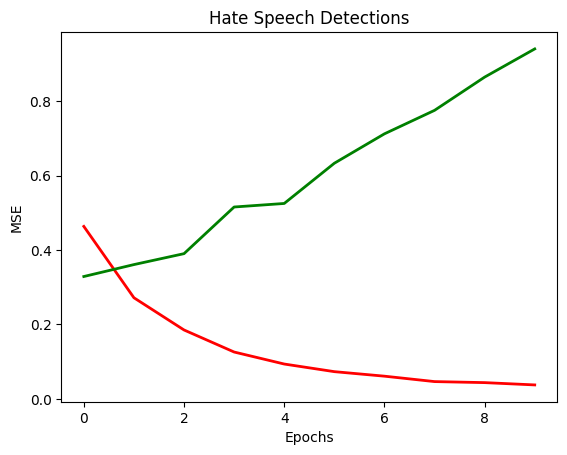

In [31]:
hist = model.history.history
plt.plot(hist['loss'],'r',linewidth=2, label='Training loss')
plt.plot(hist['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('Hate Speech Detections')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [29]:
# Save the model to a file
model.save('hate_speech_detection_english_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [32]:
import pickle

# Save the tokenizer to a file
with open('english_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tweet_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)